## Do the Estimation with SCE and SPF data


### 1. Importing Estimation algorithms 

In [1]:
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import arma_generate_sample
import pandas as pd

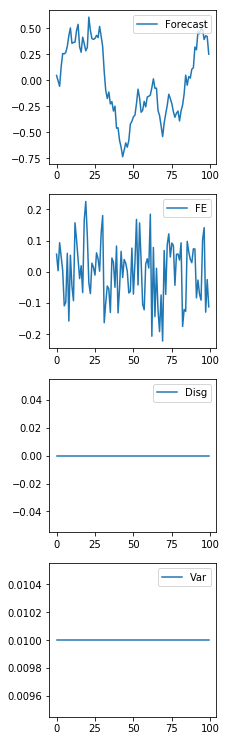

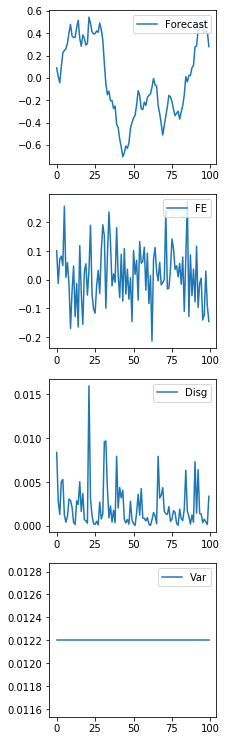

In [2]:
from GMMEst import RationalExpectation as re
from GMMEst import StickyExpectation as se
from GMMEst import ForecastPlot, ForecastPlotDiag, AR1_simulator

In [3]:
## some parameters 
rho = 0.95
sigma = 0.1
process_para = {'rho':rho,
                'sigma':sigma}

### 2. Preparing real-time data 

In [4]:
## CPI Core
InfCPICMRT=pd.read_stata('../OtherData/InfCPICMRealTime.dta')  
InfCPICMRT = InfCPICMRT[-InfCPICMRT.date.isnull()]

## CPI 
InfCPIMRT=pd.read_stata('../OtherData/InfCPIMRealTime.dta')  
InfCPIMRT = InfCPIMRT[-InfCPIMRT.date.isnull()]

In [5]:
## dealing with dates 
dateM_cpic = pd.to_datetime(InfCPICMRT['date'],format='%Y%m%d')
dateM_cpi = pd.to_datetime(InfCPIMRT['date'],format='%Y%m%d')

InfCPICMRT.index = pd.DatetimeIndex(dateM_cpic,freq='infer')
InfCPIMRT.index = pd.DatetimeIndex(dateM_cpi,freq='infer')

In [6]:
## a function that turns vintage matrix to a one-dimension vector of real time data
def GetRealTimeData(matrix):
    periods = len(matrix)
    real_time = np.zeros(periods)
    for i in range(periods):
        real_time[i] = matrix.iloc[i,i+1]
    return real_time

In [7]:
## generate real-time series 
matrix_cpic = InfCPICMRT.copy().drop(columns=['date','year','month'])
matrix_cpi = InfCPIMRT.copy().drop(columns=['date','year','month'])

real_time_cpic = pd.Series(GetRealTimeData(matrix_cpic) )
real_time_cpi =  pd.Series(GetRealTimeData(matrix_cpi) ) 
real_time_cpic.index =  InfCPICMRT.index #+ pd.DateOffset(months=1) 
real_time_cpi.index = InfCPIMRT.index #+ pd.DateOffset(months=1)

In [8]:
## turn index into yearly inflation
real_time_index =pd.concat([real_time_cpic,real_time_cpi], join='inner', axis=1)
real_time_index.columns=['RTCPI','RTCPICore']
real_time_inf = real_time_index.pct_change(periods=12)*100

In [9]:
real_time_inf.tail()

,RTCPI,RTCPICore
date,,
2019-03-01,2.019516,1.878442
2019-04-01,2.060831,1.977897
2019-05-01,2.002032,1.844054
2019-06-01,2.136764,1.773122
2019-07-01,2.186252,1.940021


### 3. Estimating using real-time inflation and expectation data


In [10]:
## exapectation data from SPF 
PopQ=pd.read_stata('../SurveyData/InfExpQ.dta')  
PopQ = PopQ[-PopQ.date.isnull()]

dateQ = pd.to_datetime(PopQ['date'],format='%Y%m%d')

dateQ_str = dateQ.dt.year.astype(int).astype(str) + \
             "Q" + dateQ.dt.quarter.astype(int).astype(str)
PopQ.index = pd.DatetimeIndex(dateQ_str)

SPFCPI = PopQ[['SPFCPI_Mean','SPFCPI_FE','SPFCPI_Disg','SPFCPI_Var']].dropna(how='any')

## Inflation data 
InfQ = pd.read_stata('../OtherData/InfShocksQClean.dta')
InfQ = InfQ[-InfQ.date.isnull()]
dateQ2 = pd.to_datetime(InfQ['date'],format='%Y%m%d')
dateQ_str2 = dateQ2 .dt.year.astype(int).astype(str) + \
             "Q" + dateQ2 .dt.quarter.astype(int).astype(str)
InfQ.index = pd.DatetimeIndex(dateQ_str2)


In [11]:
## Inflation data monthly
InfM = pd.read_stata('../OtherData/InfShocksMClean.dta')
InfM = InfM[-InfM.date.isnull()]
dateM = pd.to_datetime(InfM['date'],format='%Y%m%d')
#dateM_str = dateM .dt.year.astype(int).astype(str) + \
#             "M" + dateM .dt.month.astype(int).astype(str)
InfM.index = pd.DatetimeIndex(dateM,freq='infer')

In [12]:
## expectation data from SCE

PopM = pd.read_stata('../SurveyData/InfExpM.dta')

PopM = PopM[-PopM.date.isnull()]

dateM = pd.to_datetime(PopM['date'],format='%Y%m%d')

dateM_str = dateM.dt.year.astype(int).astype(str) + \
             "M" + dateM.dt.month.astype(int).astype(str)
PopM.index = pd.DatetimeIndex(dateM)

SCECPI = PopM[['SCE_Mean','SCE_FE','SCE_Disg','SCE_Var']].dropna(how='any')

In [13]:
## Combine expectation data and real-time data 

SPF_est = pd.concat([SPFCPI,real_time_inf,InfQ['Inf1y_CPICore'],InfQ['Inf1yf_CPICore']], join='inner', axis=1)
SCE_est = pd.concat([SCECPI,real_time_inf,InfM['Inf1yf_CPIAU']], join='inner', axis=1)

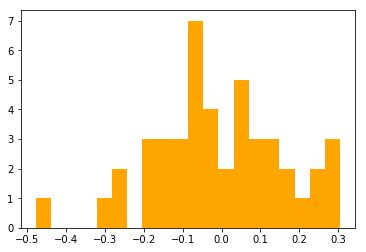

In [14]:
# How large is the difference between current vintage and real-time data
rev = SPF_est['Inf1y_CPICore'] - SPF_est['RTCPI']
hist_rv = plt.hist(rev,bins=20,color='orange')

Text(0.5, 1.0, 'Current vintage and real-time Core CPI Inflation')

<Figure size 432x288 with 0 Axes>

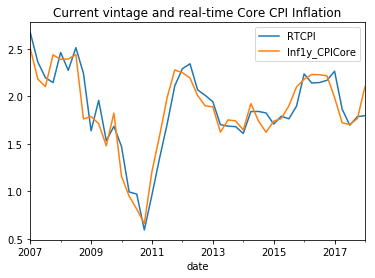

In [15]:
# real time inflation 
real_time = np.array(SPF_est['RTCPI'])
xx = plt.figure()
SPF_est[['RTCPI','Inf1y_CPICore']].plot()
plt.title('Current vintage and real-time Core CPI Inflation')

Text(0.5, 1.0, 'Realized 1-year-ahead Core CPI Inflation')

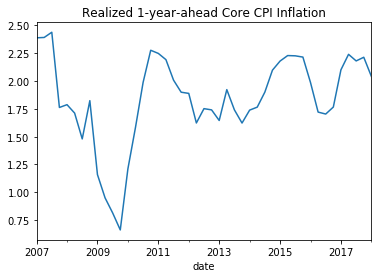

In [16]:
## realized 1-year-ahead inflation
realized_CPIC = np.array(SPF_est['Inf1yf_CPICore'])
realized_CPI = np.array(SCE_est['Inf1yf_CPIAU'])
SPF_est['Inf1yf_CPICore'].plot()
plt.title('Realized 1-year-ahead Core CPI Inflation')

In [17]:
## preparing for estimation 

exp_data_SPF = SPF_est[['SPFCPI_Mean','SPFCPI_FE','SPFCPI_Disg','SPFCPI_Var']]
exp_data_SPF.columns = ['Forecast','FE','Disg','Var']
data_moms_dct_SPF = dict(exp_data_SPF)

exp_data_SCE = SCE_est[['SCE_Mean','SCE_FE','SCE_Disg','SCE_Var']]
exp_data_SCE.columns = ['Forecast','FE','Disg','Var']
data_moms_dct_SCE = dict(exp_data_SCE)

In [18]:
## estimation for SPF
real_time = np.array(SPF_est['RTCPI'])
data_moms_dct = data_moms_dct_SPF

SE_model = se(real_time = real_time)
SE_model.GetRealization(realized_CPIC)
SE_model.GetDataMoments(data_moms_dct)
SE_model.ParaEstimate()

lbd_est_SPF = SE_model.para_est

In [19]:
## estimation for SCE
real_time = np.array(SCE_est['RTCPI'])
data_moms_dct = data_moms_dct_SCE

SE_model2 = se(real_time = realized_CPI)
SE_model2.GetRealization(realized_CPI)
SE_model2.GetDataMoments(data_moms_dct)
SE_model2.ParaEstimate()

lbd_est_SCE = SE_model2.para_est

In [20]:
## what is the estimated lambda?
print("SPF: "+str(lbd_est_SPF))
print("SCE: "+str(lbd_est_SCE))

## rough estimation that did not take care of following issues
## quarterly survey of 1-year-ahead forecast
## real-time data is yearly 

SPF: [0.72304025]
SCE: [0.06339762]


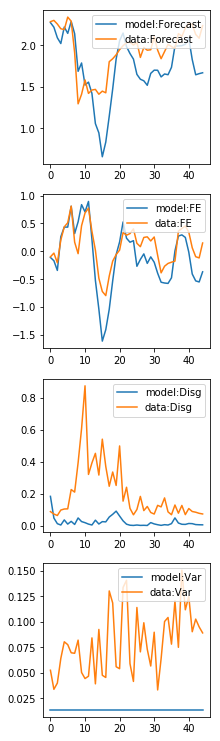

In [21]:
## compare the data with estimation for SPF

SE_para_est_SPF = {"lambda":lbd_est_SPF}

SE_model.exp_para = SE_para_est_SPF
SE_est = SE_model.SEForecaster()

ForecastPlotDiag(SE_est,data_moms_dct_SPF)

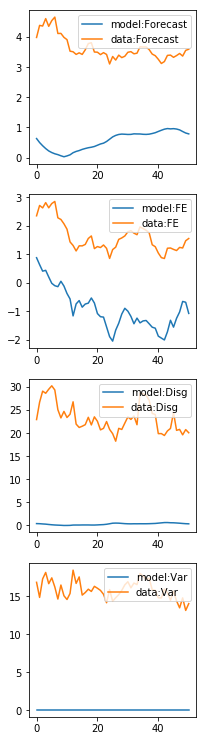

In [22]:
## compare the data with estimation for SPF

SE_para_est_SCE = {"lambda":lbd_est_SCE}
SE_model2.exp_para = SE_para_est_SCE
SE_est = SE_model2.SEForecaster()
ForecastPlotDiag(SE_est,data_moms_dct_SCE)